# Imports

In [1]:
import numpy as np
import pandas as pd

#visualize
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#presentation
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt 

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

# Acquire

In [2]:
df = pd.read_csv('GlobalLandTemperaturesByCountry.csv')
df

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland
...,...,...,...,...
577457,2013-05-01,19.059,1.022,Zimbabwe
577458,2013-06-01,17.613,0.473,Zimbabwe
577459,2013-07-01,17.000,0.453,Zimbabwe
577460,2013-08-01,19.759,0.717,Zimbabwe


# Prepare

In [3]:
# convert sale date to datetime format
df['dt'] = pd.to_datetime(df.dt)

In [4]:
# sort values by date
df = df.sort_values('dt')

In [5]:
# only keep Ireland
df = df.loc[df['Country'] == 'Ireland']

In [6]:
# set index
df = df.set_index('dt')

In [7]:
df.head()

,AverageTemperature,AverageTemperatureUncertainty,Country
dt,,,
1743-11-01,7.73,1.854,Ireland
1743-12-01,NaN,NaN,Ireland
1744-01-01,NaN,NaN,Ireland
1744-02-01,NaN,NaN,Ireland
1744-03-01,NaN,NaN,Ireland


In [8]:
df.isnull().sum()

AverageTemperature               73
AverageTemperatureUncertainty    73
Country                           0
dtype: int64

In [9]:
df.shape

(3239, 3)

In [10]:
# drop null values
df = df.dropna()

In [11]:
df.isnull().sum()

AverageTemperature               0
AverageTemperatureUncertainty    0
Country                          0
dtype: int64

In [12]:
df.shape

(3166, 3)

In [13]:
df['season'] = (df.index.month%12 + 3)//3

seasons = {
             1: 'Winter',
             2: 'Spring',
             3: 'Summer',
             4: 'Autumn'
}

df['season_name'] = df['season'].map(seasons)

In [14]:
df.head()

,AverageTemperature,AverageTemperatureUncertainty,Country,season,season_name
dt,,,,,
1743-11-01,7.730,1.854,Ireland,4,Autumn
1744-04-01,8.814,2.372,Ireland,2,Spring
1744-05-01,10.090,1.641,Ireland,2,Spring
1744-06-01,13.252,1.765,Ireland,3,Summer
1744-07-01,14.273,1.741,Ireland,3,Summer


In [15]:
df['month'] = df.index.month
df['year'] = df.index.year

In [16]:
df = df.rename(columns={'AverageTemperature':'avg_temp', 
                           'AverageTemperatureUncertainty':'temp_uncertainty',
                       'Country':'country'})

In [17]:
df.shape

(3166, 7)

In [18]:
df.head()

,avg_temp,temp_uncertainty,country,season,season_name,month,year
dt,,,,,,,
1743-11-01,7.730,1.854,Ireland,4,Autumn,11,1743
1744-04-01,8.814,2.372,Ireland,2,Spring,4,1744
1744-05-01,10.090,1.641,Ireland,2,Spring,5,1744
1744-06-01,13.252,1.765,Ireland,3,Summer,6,1744
1744-07-01,14.273,1.741,Ireland,3,Summer,7,1744


In [19]:
df.shape

(3166, 7)

In [20]:
df = pd.read_csv('GlobalLandTemperaturesByCountry.csv')

def gather_ireland(df):
    '''This funciton takes in df
    converts date to datetime format
    sorts the dates
    limits all observations to only to include Ireland
    set index to the date
    drop null values
    creates new features month and year
    rename features
    create season feature
    return cleaned df'''
    # convert sale date to datetime format
    df['dt'] = pd.to_datetime(df.dt)
    # sort values by date
    df = df.sort_values('dt')
    # only keep Ireland
    df = df.loc[df['Country'] == 'Ireland']
    # set index
    df = df.set_index('dt')
    # drop null values
    df = df.dropna()
    # create month and year features
    df['month'] = df.index.month
    df['year'] = df.index.year
    # rename
    df = df.rename(columns={'AverageTemperature':'avg_temp', 
                           'AverageTemperatureUncertainty':'temp_uncertainty',
                       'Country':'country'})
    return df

df = gather_ireland(df)
df.head()

,avg_temp,temp_uncertainty,country,month,year
dt,,,,,
1743-11-01,7.730,1.854,Ireland,11,1743
1744-04-01,8.814,2.372,Ireland,4,1744
1744-05-01,10.090,1.641,Ireland,5,1744
1744-06-01,13.252,1.765,Ireland,6,1744
1744-07-01,14.273,1.741,Ireland,7,1744


# Explore

In [21]:
df.shape

(3166, 5)

In [22]:
# Lets use 70/30 train test split %

train_size = .70
n = df.shape[0]
test_start_index = round(train_size * n)
test_start_index

2216

In [23]:
# 50% of total size
train_size = int(len(df) * .6)
train_size

1899

In [24]:
validate_size = int(len(df) * .3)
validate_size

949

In [25]:
# whatever is left after train and validate
test_size = int(len(df) - train_size - validate_size)
test_size

318

In [26]:
# train plus validate size
validate_end_index = train_size + validate_size
validate_end_index

2848

In [27]:
train = df[: train_size]
validate = df[train_size:validate_end_index]
test = df[validate_end_index:]

In [28]:
validate

,avg_temp,temp_uncertainty,country,month,year
dt,,,,,
1908-02-01,6.654,0.446,Ireland,2,1908
1908-03-01,5.305,0.464,Ireland,3,1908
1908-04-01,6.453,0.381,Ireland,4,1908
1908-05-01,11.484,0.475,Ireland,5,1908
1908-06-01,13.070,0.476,Ireland,6,1908
...,...,...,...,...,...
1986-10-01,10.531,0.194,Ireland,10,1986
1986-11-01,7.859,0.199,Ireland,11,1986
1986-12-01,6.189,0.188,Ireland,12,1986


In [29]:
# create a series called 'y'
y = train.avg_temp

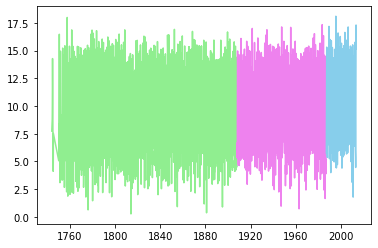

In [30]:
plt.plot(train.index, train.avg_temp, color='lightgreen')
plt.plot(validate.index, validate.avg_temp, color='violet')
plt.plot(test.index, test.avg_temp, color='skyblue')

Text(0.5, 1.0, 'Average Temp Yearly Distribution')

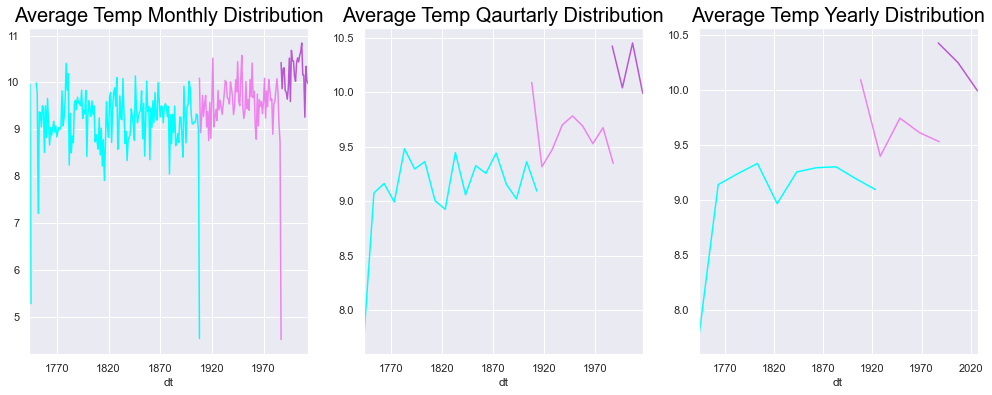

In [31]:
plt.subplots(1, 3, figsize=(17,6), sharey=True)
sns.set(style="darkgrid")
y = train.avg_temp

plt.subplot(1,3,1)
train.resample('Y').avg_temp.mean().plot(color='cyan')
validate.resample('Y').avg_temp.mean().plot(color='violet')
test.resample('Y').avg_temp.mean().plot(color='mediumorchid')
plt.title('Average Temp Monthly Distribution',size=20, color='black')

plt.subplot(1,3,2)
train.resample('10Y').avg_temp.mean().plot(color='cyan')
validate.resample('10Y').avg_temp.mean().plot(color='violet')
test.resample('10Y').avg_temp.mean().plot(color='mediumorchid')
plt.title('Average Temp Qaurtarly Distribution',size=20, color='black')

plt.subplot(1,3,3)
train.resample('20Y').avg_temp.mean().plot(color='cyan')
validate.resample('20Y').avg_temp.mean().plot(color='violet')
test.resample('20Y').avg_temp.mean().plot(color='mediumorchid')
plt.title('Average Temp Yearly Distribution',size=20, color='black')

<AxesSubplot:ylabel='Frequency'>

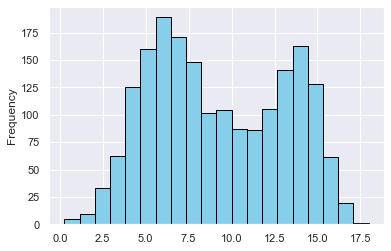

In [32]:
# plot a histogram of temperature
y.plot.hist(bins =20, color='skyblue', edgecolor='black')

Text(0.5, 1.0, 'Avg Temp by Year')

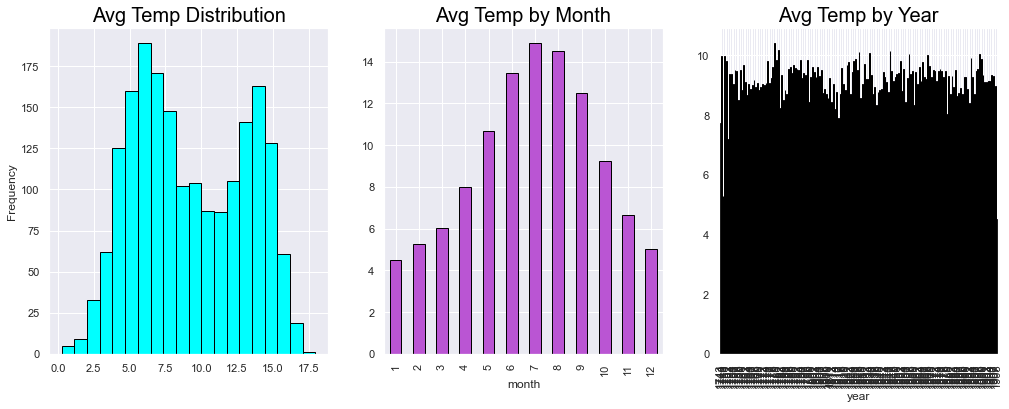

In [33]:
plt.subplots(1, 3, figsize=(17,6), sharey=True)
sns.set(style="darkgrid")
y = train.avg_temp

plt.subplot(1,3,1)
y.plot.hist(bins =20, color='cyan', edgecolor='black')
plt.title('Avg Temp Distribution', size=20, color='black')

plt.subplot(1,3,2)
train.groupby('month').avg_temp.mean().plot.bar(color='mediumorchid', edgecolor='black')
plt.title('Avg Temp by Month',size=20, color='black')

plt.subplot(1,3,3)
train.groupby('year').avg_temp.mean().plot.bar(color='blueviolet', edgecolor='black')
plt.title('Avg Temp by Year',size=20, color='black')

Text(0.5, 1.0, 'Sales Amount by Month')

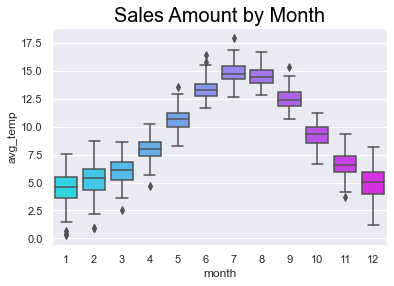

In [34]:

sns.boxplot(data = train, x = 'month', y = 'avg_temp', palette='cool')
plt.title('Sales Amount by Month', size=20, color='black')


<AxesSubplot:title={'center':'All Plots Stacked'}, xlabel='dt'>

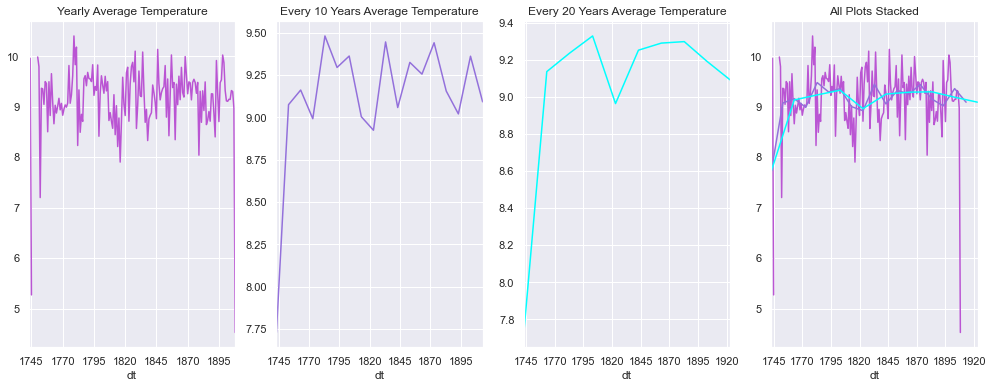

In [35]:
plt.subplots(1, 4, figsize=(17,6), sharey=True)
sns.set(style="darkgrid")
y = train.avg_temp

plt.subplot(1,4,1)
y.resample('Y').mean().plot(title='Yearly Average Temperature', color='mediumorchid')

plt.subplot(1,4,2)
y.resample('10Y').mean().plot(title='Every 10 Years Average Temperature', color='mediumpurple')

plt.subplot(1,4,3)
y.resample('20Y').mean().plot(title='Every 20 Years Average Temperature', color='cyan')

plt.subplot(1,4,4)
y.resample('Y').mean().plot(title='All Plots Stacked', color='mediumorchid')
y.resample('10Y').mean().plot(title='All Plots Stacked', color='mediumpurple')
y.resample('20Y').mean().plot(title='All Plots Stacked', color='cyan')

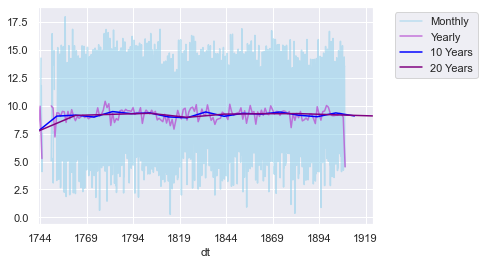

In [36]:
y.resample('M').mean().plot(alpha=.5, label='Monthly', color='skyblue')
y.resample('Y').mean().plot(alpha=.8, label='Yearly', color='mediumorchid')
y.resample('10Y').mean().plot(label='10 Years', color='blue')
y.resample('20Y').mean().plot(label='20 Years', color='purple')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [37]:
y = train.avg_temp.resample('10Y').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()

,y,trend,seasonal,resid
dt,,,,
1743-12-31,7.730000,7.730000,0.0,0.0
1753-12-31,9.075673,9.075673,0.0,0.0
1763-12-31,9.162025,9.162025,0.0,0.0
1773-12-31,8.992675,8.992675,0.0,0.0
1783-12-31,9.481483,9.481483,0.0,0.0


<AxesSubplot:xlabel='dt'>

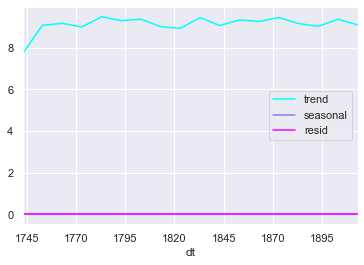

In [38]:
decomposition.iloc[:, 1:].plot(cmap='cool')

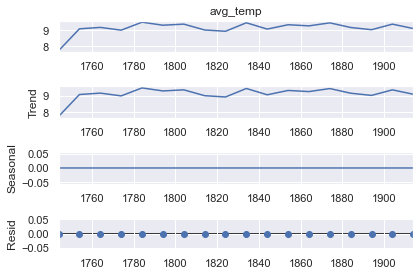

In [39]:
# the value returned from seasonal_decompose can itself be plotted:
result.plot()
None

In [40]:
# create a categorical feature
train['temp_bin'] = pd.qcut(train.avg_temp, 4, labels=['cold', 'cool', 'warm', 'hot'])
train.groupby('temp_bin').avg_temp.mean()

temp_bin
cold     4.520983
cool     7.146731
warm    10.806633
hot     14.375480
Name: avg_temp, dtype: float64

In [41]:
train.groupby('temp_bin').resample('10Y').size().unstack(0).fillna(0).apply(lambda row: row / row.sum(), axis=1).head()

temp_bin,cold,cool,warm,hot
dt,,,,
1743-12-31,0.000000,1.0,0.000000,0.000000
1744-12-31,0.142857,0.0,0.571429,0.285714
1753-12-31,0.000000,1.0,0.000000,0.000000
1754-12-31,0.394737,0.0,0.263158,0.342105
1763-12-31,0.000000,1.0,0.000000,0.000000


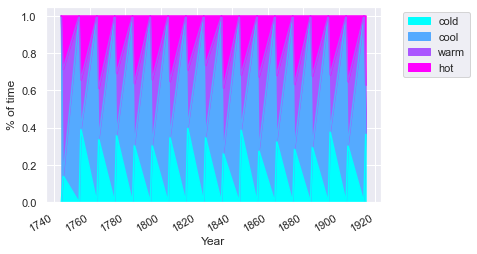

In [42]:
(train.groupby('temp_bin')
 .resample('10Y')
 .size() # like COUNT(*)
 .unstack(0) # turns an index level into columns
 .fillna(0)
 .astype(int)
 .apply(lambda row: row / row.sum(), axis=1) # raw nums to % of the row
     # take each row and say take that value adn idvide by the total
 .plot.area(cmap='cool')
)
plt.ylabel('% of time')
plt.xlabel('Year')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

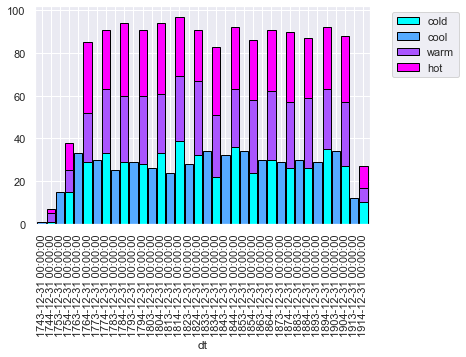

In [43]:
ax = (train
 .groupby('temp_bin')
 .resample('10Y')
 .size()
 .unstack(0)
 .plot.bar(stacked=True, width=.9, ec='black',cmap='cool')
)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

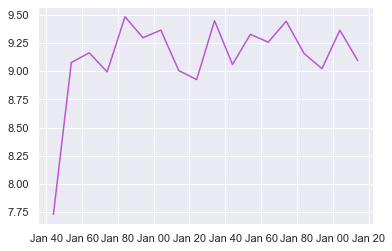

In [44]:
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots()

weekly = y.resample('10Y').mean()

ax.plot(weekly.index, weekly, color='mediumorchid')

ax.xaxis.set_major_formatter(DateFormatter('%b %y'))

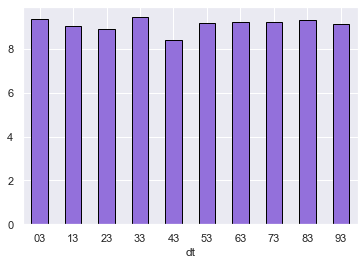

In [45]:
ax = y.groupby(y.index.strftime('%m-%y')).mean().plot.bar(color='mediumpurple', edgecolor='black')
ax.set_xticklabels([t.get_text()[3:] for t in ax.get_xticklabels()], rotation=0)
None

[Text(0.5, 0, 'Average Temp of Ireland'), Text(0, 0.5, 'Temp + 1')]

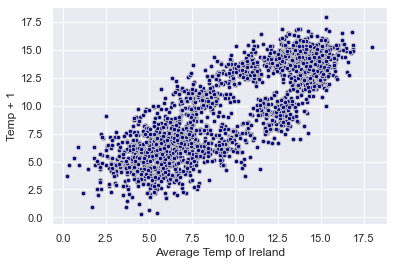

In [46]:
train['y(t + 1)'] = train.avg_temp.shift(-1)
ax = train.plot.scatter(x='avg_temp', y='y(t + 1)', color='navy', edgecolor='silver')
ax.set(xlabel='Average Temp of Ireland', ylabel='Temp + 1')

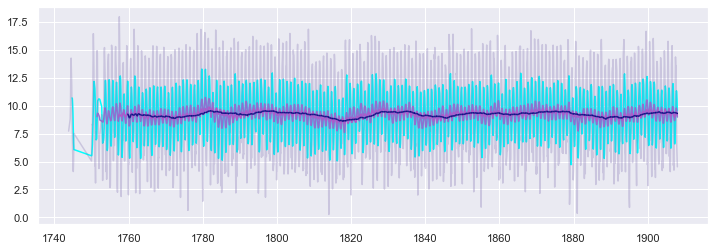

In [47]:
# train['dollars_sold'].tail(30)
plt.figure(figsize=(12,4))
plt.plot(train['avg_temp'].rolling(7).mean(), color='cyan')
plt.plot(train['avg_temp'].rolling(30).mean(), color='mediumpurple')
plt.plot(train['avg_temp'].rolling(90).mean(), color='mediumorchid')
plt.plot(train['avg_temp'].rolling(120).mean(), color='navy')
plt.plot(train['avg_temp'], alpha=.3, color='m')

# Model

In [68]:
yhat_df['avg_temp']

dt
1908-02-01    4.53
1908-03-01    4.53
1908-04-01    4.53
1908-05-01    4.53
1908-06-01    4.53
              ... 
1986-10-01    4.53
1986-11-01    4.53
1986-12-01    4.53
1987-01-01    4.53
1987-02-01    4.53
Name: avg_temp, Length: 949, dtype: float64

In [48]:
def make_predictions():
    yhat_df = pd.DataFrame({'avg_temp': [AverageTemperature], 
                        'temp_uncertainty': [TemperatureUncertainty]}, 
                      index = validate.index)
    return yhat_df

def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 8)
    return rmse

def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.2f}'.format(rmse))
    plt.show()
    
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)


In [49]:
temp = round(train['avg_temp'][-1:][0], 2)
temp

4.53

In [50]:
uncertain = round(train['temp_uncertainty'][-1:][0], 2)
uncertain

0.52

In [51]:
yhat_df = pd.DataFrame({'avg_temp': [temp], 
                        'temp_uncertainty': [uncertain]}, 
                      index = validate.index)

yhat_df.head()

,avg_temp,temp_uncertainty
dt,,
1908-02-01,4.53,0.52
1908-03-01,4.53,0.52
1908-04-01,4.53,0.52
1908-05-01,4.53,0.52
1908-06-01,4.53,0.52


avg_temp -- RMSE: 6.25


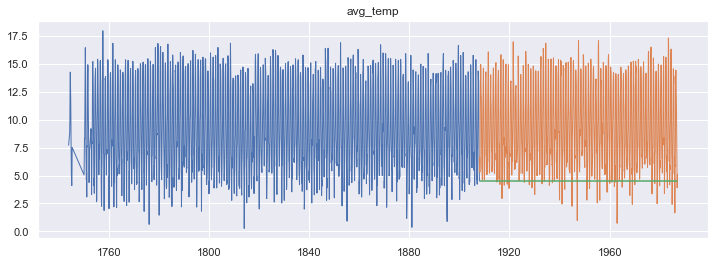

temp_uncertainty -- RMSE: 0.23


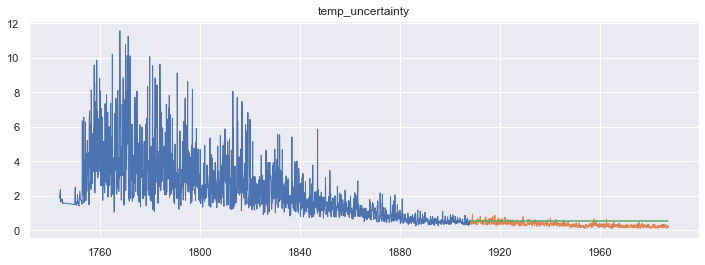

In [52]:
plot_and_eval('avg_temp')
plot_and_eval('temp_uncertainty')

In [53]:
eval_df = append_eval_df(model_type = 'last_observed_value', 
                         target_var = 'avg_temp')
eval_df = append_eval_df(model_type = 'last_observed_value', 
                         target_var = 'temp_uncertainty')
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,6.245025
1,last_observed_value,temp_uncertainty,0.225230


## Simple Average

In [54]:
yhat_df = pd.DataFrame({'avg_temp': [temp],
                           'temp_uncertainty': [uncertain]}, 
                           index = validate.index)
yhat_df = pd.DataFrame({'temp_uncertainty': [uncertain],
                           'avg_temp': [temp]}, 
                           index = validate.index)

In [55]:
yhat_df.head()

,temp_uncertainty,avg_temp
dt,,
1908-02-01,0.52,4.53
1908-03-01,0.52,4.53
1908-04-01,0.52,4.53
1908-05-01,0.52,4.53
1908-06-01,0.52,4.53


In [56]:
yhat_df.describe()

,temp_uncertainty,avg_temp
count,9.490000e+02,9.490000e+02
mean,5.200000e-01,4.530000e+00
std,6.442689e-15,7.198039e-14
min,5.200000e-01,4.530000e+00
25%,5.200000e-01,4.530000e+00
50%,5.200000e-01,4.530000e+00
75%,5.200000e-01,4.530000e+00
max,5.200000e-01,4.530000e+00


In [57]:
eval_df = append_eval_df(model_type='simple_average', 
                            target_var = 'avg_temp')
eval_df = append_eval_df(model_type='simple_average', 
                            target_var = 'temp_uncertainty')
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,6.245025
1,last_observed_value,temp_uncertainty,0.225230
2,simple_average,avg_temp,6.245025
3,simple_average,temp_uncertainty,0.225230


In [58]:
print(train['avg_temp'].rolling(30).mean()[29])
print(train['avg_temp'].head(30).mean())

9.019866666666667
9.019866666666667


In [59]:
period = 30
# take 30 day rolling avg then take the last element 
    # that will be the one that propegates forward as our prediction
temp = round(train['avg_temp'].rolling(period).mean()[-1], 2) 
    # we want the most recent hence the -1
year = round(train['temp_uncertainty'].rolling(period).mean()[-1], 2)

print(temp, year)

8.99 0.48


In [60]:
periods = [4, 12, 26, 52, 104] # each of these are periods 

for p in periods: 
    temp = round(train['avg_temp'].rolling(p).mean()[-1], 2)
    year = round(train['temp_uncertainty'].rolling(p).mean()[-1],2)
    model_type = str(p) + 'd_moving_avg'
    eval_df = append_eval_df(model_type = model_type, 
                                 target_var = 'avg_temp')
    eval_df = append_eval_df(model_type = model_type, 
                                 target_var = 'temp_uncertainty')

In [61]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,6.245025
1,last_observed_value,temp_uncertainty,0.225230
2,simple_average,avg_temp,6.245025
3,simple_average,temp_uncertainty,0.225230
4,4d_moving_avg,avg_temp,6.245025
5,4d_moving_avg,temp_uncertainty,0.225230
6,12d_moving_avg,avg_temp,6.245025
7,12d_moving_avg,temp_uncertainty,0.225230
8,26d_moving_avg,avg_temp,6.245025
9,26d_moving_avg,temp_uncertainty,0.225230


In [62]:
min_items_rmse = eval_df[eval_df.target_var == 'avg_temp']['rmse'].min()

eval_df[eval_df.rmse == min_items_rmse]

,model_type,target_var,rmse
0,last_observed_value,avg_temp,6.245025
2,simple_average,avg_temp,6.245025
4,4d_moving_avg,avg_temp,6.245025
6,12d_moving_avg,avg_temp,6.245025
8,26d_moving_avg,avg_temp,6.245025
10,52d_moving_avg,avg_temp,6.245025
12,104d_moving_avg,avg_temp,6.245025


In [63]:
eval_df = append_eval_df(model_type = 'holts_.1', 
                            target_var = 'avg_temp')
eval_df = append_eval_df(model_type = 'holts_.1', 
                            target_var = 'temp_uncertainty')
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
1,last_observed_value,temp_uncertainty,0.225230
3,simple_average,temp_uncertainty,0.225230
5,4d_moving_avg,temp_uncertainty,0.225230
7,12d_moving_avg,temp_uncertainty,0.225230
9,26d_moving_avg,temp_uncertainty,0.225230
11,52d_moving_avg,temp_uncertainty,0.225230
13,104d_moving_avg,temp_uncertainty,0.225230
15,holts_.1,temp_uncertainty,0.225230
0,last_observed_value,avg_temp,6.245025
2,simple_average,avg_temp,6.245025


In [64]:
temp_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

year_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

# find which model that is
eval_df[((eval_df.rmse == temp_min_rmse) | 
         (eval_df.rmse == year_min_rmse))]

,model_type,target_var,rmse
0,last_observed_value,avg_temp,6.245025
1,last_observed_value,temp_uncertainty,0.225230
2,simple_average,avg_temp,6.245025
3,simple_average,temp_uncertainty,0.225230
4,4d_moving_avg,avg_temp,6.245025
5,4d_moving_avg,temp_uncertainty,0.225230
6,12d_moving_avg,avg_temp,6.245025
7,12d_moving_avg,temp_uncertainty,0.225230
8,26d_moving_avg,avg_temp,6.245025
9,26d_moving_avg,temp_uncertainty,0.225230


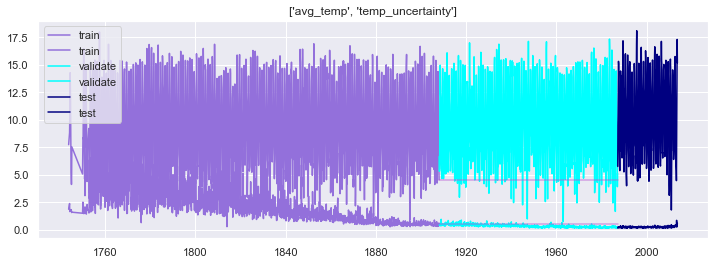

In [65]:
target_var = ['avg_temp','temp_uncertainty']

def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train', color='mediumpurple')
    plt.plot(validate[target_var], label='validate', color='cyan')
    plt.plot(test[target_var], label='test', color='navy')
    plt.plot(yhat_df[target_var], alpha=.5, color='mediumorchid')
    plt.title(target_var)
    plt.legend()
    plt.show()
    
final_plot(target_var)

In [66]:
rmse_avg_temp = sqrt(mean_squared_error(test['avg_temp'], 
                                       yhat_df['avg_temp']))

rmse_avg_uncertainty = sqrt(mean_squared_error(test['temp_uncertainty'], 
                                       yhat_df['temp_uncertainty']))

print('rmse_avg_temp: ', rmse_avg_temp)
print('rmse_avg_uncertainty: ', rmse_avg_uncertainty)

ValueError: Found input variables with inconsistent numbers of samples: [318, 949]